In [18]:
import os
import shutil

# 대상 상위 폴더를 지정합니다.
base_dir = r'C:\Project\Python_basic\미드나잇\image\페트병'

# base_dir 하위의 모든 폴더를 탐색합니다.
for root, dirs, files in os.walk(base_dir):
    # 하위 폴더에 있는 파일들을 상위 폴더로 이동합니다.
    for file in files:
        # 파일의 전체 경로를 설정합니다.
        file_path = os.path.join(root, file)
        # 파일을 상위 폴더(base_dir)로 이동합니다.
        shutil.move(file_path, base_dir)

# 하위 폴더가 비었으면 삭제합니다.
for root, dirs, files in os.walk(base_dir, topdown=False):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

print("모든 하위 폴더 내의 이미지 파일들이 상위 폴더로 이동되었습니다.")


Error: Destination path 'C:\Project\Python_basic\미드나잇\image\페트병\23_X001_C012_1027_0.jpg' already exists

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# GPU가 있으면 GPU를, 없으면 CPU를 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 경로 설정
data_dir = r"C:\Project\Python_basic\미드나잇\image"

# 하이퍼파라미터 설정
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# 이미지 전처리 (크기 조정, 텐서 변환, 정규화 등)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [21]:
# 각 클래스에서 1000개씩만 샘플링
indices = []
targets = full_dataset.targets
for class_index in range(len(full_dataset.classes)):
    class_indices = [i for i in range(len(full_dataset)) if full_dataset.targets[i] == class_index]
    indices.extend(class_indices[:1000])

# 80:20으로 학습 및 검증/테스트 데이터셋 분할
train_indices, val_test_indices = train_test_split(indices, test_size=0.2, stratify=[targets[i] for i in indices], random_state=42)

# 학습용과 검증용 데이터셋
train_dataset = Subset(full_dataset, train_indices)
val_test_dataset = Subset(full_dataset, val_test_indices)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_test_loader = DataLoader(val_test_dataset, batch_size=batch_size, shuffle=False)

# 모델 불러오기 (ResNet-18)
model = models.resnet18(pretrained=True)

# 마지막 레이어를 커스터마이징 (클래스 개수 2개)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\Admin\miniconda3\envs\gumi_env310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\gumi_env310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
best_acc = 0.0  # 베스트 모델의 정확도 추적

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm으로 DataLoader 감싸기
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 현재 손실값과 정확도를 tqdm에 표시
        progress_bar.set_postfix({
            'Loss': f'{running_loss/len(train_loader):.4f}', 
            'Acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # 검증 과정 추가
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # 베스트 모델 업데이트
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_can_pet.pth")
        print(f"Best model updated at epoch {epoch+1} with validation accuracy: {best_acc:.2f}%")

print("학습 완료!")


Epoch 1/10, Loss: 0.4395, Accuracy: 80.81%
Validation Accuracy: 79.75%
Best model updated at epoch 1 with validation accuracy: 79.75%


Epoch 2/10, Loss: 0.1959, Accuracy: 91.81%
Validation Accuracy: 91.75%
Best model updated at epoch 2 with validation accuracy: 91.75%


Epoch 3/10, Loss: 0.1308, Accuracy: 94.62%
Validation Accuracy: 84.75%


Epoch 4/10, Loss: 0.1248, Accuracy: 95.38%
Validation Accuracy: 89.50%


Epoch 5/10, Loss: 0.0605, Accuracy: 97.94%
Validation Accuracy: 85.75%


Epoch 6/10, Loss: 0.0454, Accuracy: 98.69%
Validation Accuracy: 89.00%


Epoch 7/10, Loss: 0.1182, Accuracy: 95.81%
Validation Accuracy: 85.50%


Epoch 8/10, Loss: 0.0591, Accuracy: 98.44%
Validation Accuracy: 91.00%


Epoch 9/10, Loss: 0.0387, Accuracy: 98.44%
Validation Accuracy: 91.25%


Epoch 10/10, Loss: 0.0320, Accuracy: 98.75%
Validation Accuracy: 84.50%
학습 완료!


In [28]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 전체 데이터셋 로드
data_dir = "C:\\Project\\Python_basic\\미드나잇\\image"
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# 특정 파일을 반드시 포함하도록 필터링
required_files = [i for i, (path, _) in enumerate(full_dataset.samples) if "KakaoTalk_2024" in os.path.basename(path)]
print(f"Required files found: {len(required_files)}")

# 나머지에서 무작위로 100개의 이미지 선택
other_indices = [i for i in range(len(full_dataset)) if i not in required_files]
additional_indices = other_indices[:100]

# 최종 학습에 사용할 인덱스
final_indices = required_files + additional_indices

# 데이터셋 분할
train_dataset = Subset(full_dataset, final_indices)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 기존 학습된 모델 로드
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 두 클래스 ('캔', '페트병')
model.load_state_dict(torch.load("best_resnet18_can_pet.pth", map_location=device))
model = model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 추가 학습 수행
num_epochs = 5  # 추가 학습할 에포크 수

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# 추가 학습된 모델 저장
torch.save(model.state_dict(), "fine_tuned_resnet18_can_pet.pth")
print("추가 학습 완료 및 모델 저장!")


Required files found: 100
Epoch 1/5, Loss: 0.4400, Accuracy: 80.50%
Epoch 2/5, Loss: 0.2861, Accuracy: 92.50%
Epoch 3/5, Loss: 0.1688, Accuracy: 95.00%
Epoch 4/5, Loss: 0.1330, Accuracy: 94.50%
Epoch 5/5, Loss: 0.0360, Accuracy: 99.50%
추가 학습 완료 및 모델 저장!


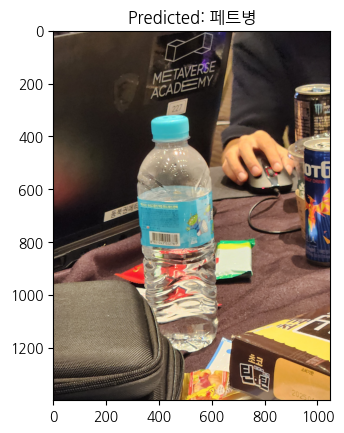

Prediction: 페트병


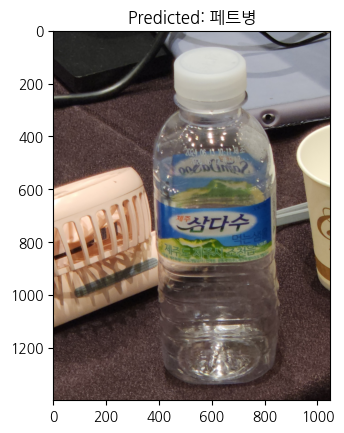

Prediction: 페트병


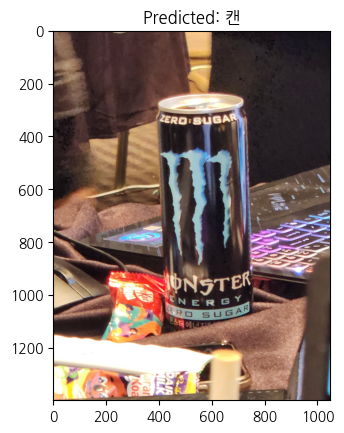

Prediction: 캔


In [33]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import koreanize_matplotlib
from torchvision import transforms, models
import os

# 디바이스 설정 (GPU 사용 가능 시 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 예측 함수
def predict_image(model, image_path, class_names):
    model.eval()
    with torch.no_grad():
        try:
            image = Image.open(image_path)
            image_tensor = test_transform(image).unsqueeze(0).to(device)
            outputs = model(image_tensor)
            _, preds = torch.max(outputs, 1)

            # 이미지 출력
            plt.imshow(image)
            plt.title(f'Predicted: {class_names[preds.item()]}')
            plt.show()
            print(f"Prediction: {class_names[preds.item()]}")
        except Exception as e:
            print(f"Error in prediction: {e}")

# 학습된 모델 불러오기
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 클래스 개수 2개로 설정
model.load_state_dict(torch.load("fine_tuned_resnet18_can_pet.pth", map_location=device))
model = model.to(device)

# 평가할 이미지 파일 경로 설정
image_paths = [
    "C:\\Project\\Python_basic\\미드나잇\\KakaoTalk_20240821_234752307.jpg",
    "C:\\Project\\Python_basic\\미드나잇\\소형.jpg",
    "C:\\Project\\Python_basic\\미드나잇\\sad.jpg"
]

# 파일 존재 여부 확인 및 예측 수행
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Error: The file {image_path} does not exist.")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Provided path: {image_path}")
    else:
        predict_image(model, image_path, ['캔', '페트병'])


In [44]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import os

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 추가 학습할 이미지 경로
additional_data_dir = "C:\\Project\\Python_basic\\미드나잇\\additional_images"

# 추가 학습할 데이터셋 로드
additional_dataset = datasets.ImageFolder(additional_data_dir, transform=data_transforms)
additional_loader = DataLoader(additional_dataset, batch_size=4, shuffle=True)

# 기존 학습된 모델 로드
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 클래스 개수 2개로 설정
model.load_state_dict(torch.load("fine_tuned_resnet18_can_pet.pth", map_location=device))
model = model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 파인 튜닝이므로 낮은 학습률 사용

# 추가 학습 수행
num_epochs = 4  # 추가 학습할 에포크 수

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in additional_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(additional_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# 추가 학습된 모델 저장
torch.save(model.state_dict(), "fine_tuned_resnet18_additional.pth")
print("추가 학습 완료 및 모델 저장!")


Epoch 1/4, Loss: 1.2867, Accuracy: 58.93%
Epoch 2/4, Loss: 0.3259, Accuracy: 80.36%
Epoch 3/4, Loss: 0.2060, Accuracy: 94.64%
Epoch 4/4, Loss: 0.3642, Accuracy: 89.29%
추가 학습 완료 및 모델 저장!
